# Лабораторная №2

## GARCH-модели - это весело
Для данных я использовала готовую библиотеку YFinance, которые берет котировки акций с Yahoo Finance, для самого предсказания возьмем индекс S&P500, будем предсказывать для него реализованную волатильность. Да, котировки не слишком интересно, но зато модель была чем-то новым

Иногда установка капризничает, так что нужно прописать pip install yfinance

In [4]:
%%capture
!pip install yfinance
!pip install arch
#!pip install -i https://pypi.anaconda.org/ranaroussi/simple finance

import yfinance as yf 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import custom_garch
from arch import arch_model
import sys
from sklearn.metrics import mean_absolute_percentage_error

ModuleNotFoundError: No module named 'yfinance'

### Сбор и предобработка данных

In [2]:
data = yf.Ticker("^GSPC").history(period="1y")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-23 00:00:00-05:00,3815.110107,3845.800049,3797.010010,3844.820068,2819280000,0.0,0.0
2022-12-27 00:00:00-05:00,3843.340088,3846.649902,3813.219971,3829.250000,3030300000,0.0,0.0
2022-12-28 00:00:00-05:00,3829.560059,3848.320068,3780.780029,3783.219971,3083520000,0.0,0.0
2022-12-29 00:00:00-05:00,3805.449951,3858.189941,3805.449951,3849.280029,3003680000,0.0,0.0
2022-12-30 00:00:00-05:00,3829.060059,3839.850098,3800.340088,3839.500000,2979870000,0.0,0.0


В целом без разницы, какой из индикаторов использовать. Можно брать открытие, закрытие, минимальная или максимальная цена. Поэтому будем считать волатильность по цене открытия. Но нарисуем её для начала

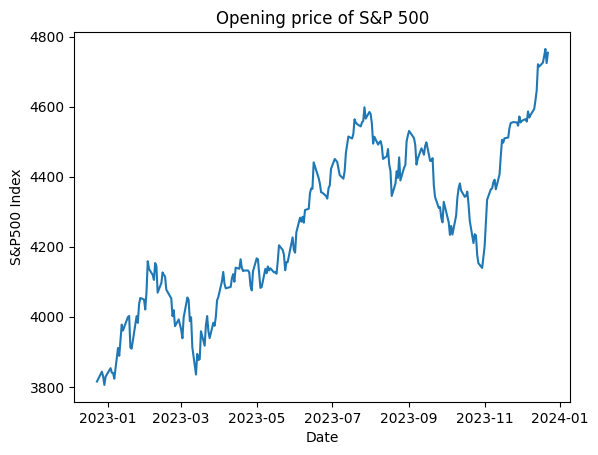

In [3]:
plt.plot(data['Open'])
plt.title('Opening price of S&P 500')
plt.ylabel('S&P500 Index')
plt.xlabel('Date')
plt.show()

Видно, что ряд не стационарный, но пока нас это не особо беспокоит. Посчитаем [реализованную волатильность](https://quantra.quantinsti.com/glossary/Realized-Volatility)

Она считается из логарифмической доходности, затем с помощью скользящего окна считается по нескольким дням.


Log returns: $$ R_t = 100 * ln(\dfrac{P_t}{P_{t-1}})$$

Realized volatility - standart deviation of log returns


Для реализованной волатильности беру окно длительностью в 21 дней, чтобы считать помесячно, т.к. в месяце в среднем 21 торговый день

In [4]:
data['Log_returns'] = custom_garch.calculate_log_returns(data)

In [5]:
data['RV'] = custom_garch.calculate_rv(data, 21)

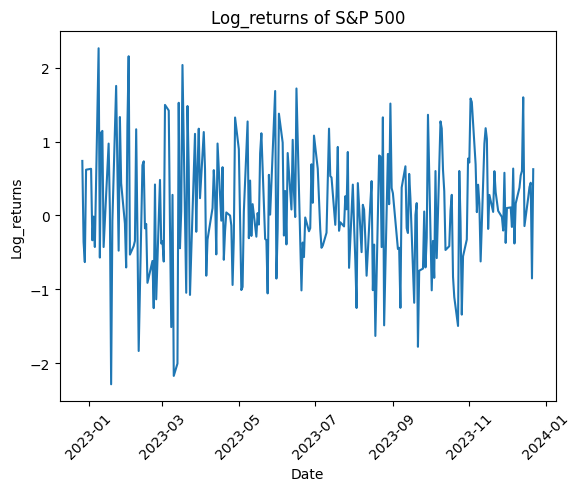

In [6]:
plt.plot(data['Log_returns'])
plt.title('Log_returns of S&P 500')
plt.ylabel('Log_returns')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.show()

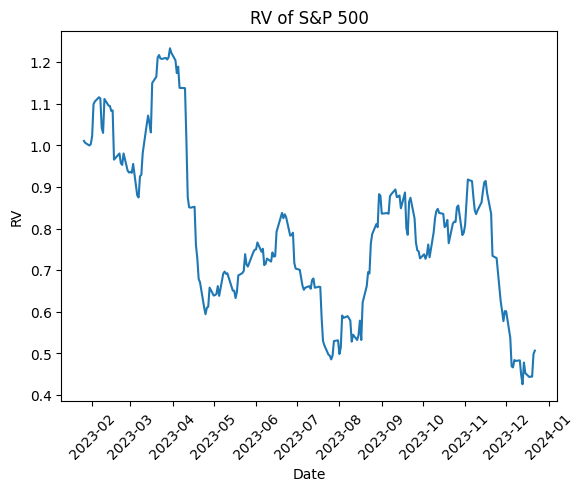

In [7]:
plt.plot(data['RV'])
plt.title('RV of S&P 500')
plt.ylabel('RV')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.show()

Специфика GARCH-моделей заключается в том, что не нужно избавляться от тренда, даже если он есть. Поэтому дальше спокойно начинаем предсказательную работу

Мы пытаемся объяснить разброс наблюдаемой переменной, следующим образом:

Рассмотрим простейшую модель GARCH(1, 1)
$$\begin{cases} X_t = e_t \sigma_t \\
\sigma^2_t = \omega + \alpha X_{t-1}^2 + \beta \sigma_{t-1}^2
\end{cases}$$

Фактически, GARCH - модель - определяет условную дисперсию как сумму предыдущих квадратов остатков условного среднего и предыдущих значений условной дисперсии.

Модель очень хорошо интерпретируется

$\omega$ - безусловное значение волатильности

$\alpha$ - реакция волатильности на предыдущий шок

$\beta$ - сохранение эффекта, (длительность периодов низкой и высокой волатильности)

### Моделирование стандартными стат. пакетами

In [8]:
data.dropna(inplace=True)

In [ ]:
model = arch_model(data['Log_returns'], vol="Garch", p=1, o=0, q=1, mean='zero')
res = model.fit()

In [ ]:
res

### Моделирование с помощью собственной функции

In [ ]:
params = custom_garch.fit_garch(data['Log_returns'])
print('My model coefs are:', params)

Как можно заметить, отличие в коэффициентах незначительные, более того мои коэффициенты попадают в 95% доверительный интервал для GARCH-модели из стат пакета

### Предсказание и сравнение результатов

In [ ]:
# 50 предсказаний с помощью GARCH-модели
split_date = data.iloc[-200:].index
garch_predicts = res.forecast(start = split_date[0], horizon = 1).variance.iloc[-200:] / 100

In [13]:
custom_predicts = pd.DataFrame(index = garch_predicts.index)
custom_predicts['h1'] = custom_garch.garch_apply(data['Log_returns'], params)[-200:] / 100

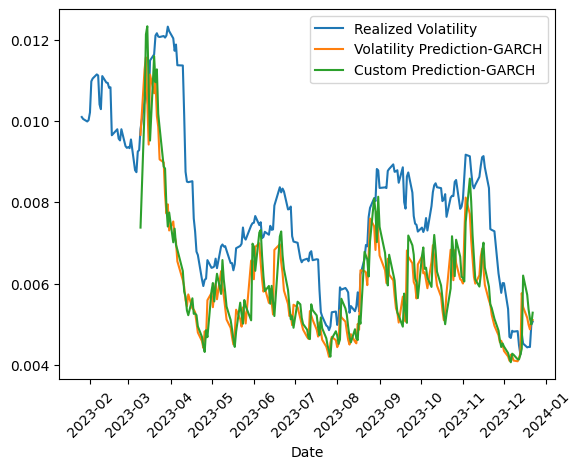

In [14]:
plt.plot(data['RV'] / 100, label='Realized Volatility')
plt.plot(garch_predicts, label='Volatility Prediction-GARCH')
plt.plot(custom_predicts, label='Custom Prediction-GARCH')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

Как видим, несмотря на достаточно высокое значение скользящего окна и низкое значение лагов в модели качество предсказания относительно неплохое

При этом кастомный гарч несильно отличается от гарча из коробки. Различия в моделях возможны из-за различных стартовых параметров оптимизации и различных методов оптимизации

### Теперь сделаем предсказания на новые данные

In [ ]:
model = arch_model(data['Log_returns'][:-10], vol="Garch", p=1, o=0, q=1, mean='zero')
res = model.fit()
forecast_horizon = 10
forecast = res.forecast(horizon=forecast_horizon)
garch_forecast = forecast.variance.iloc[-1] / 100
garch_forecast

In [ ]:
params = custom_garch.fit_garch(data['Log_returns'][:-10])
custom_forecast = custom_garch.garch_forecast(forecast_horizon, data['Log_returns'][:-10], params) / 100
custom_forecast

In [ ]:
print('Python GARCH MAPE:', mean_absolute_percentage_error(data['RV'][-10:] / 100, garch_forecast))
print('Custom GARCH MAPE:', mean_absolute_percentage_error(data['RV'][-10:] / 100, custom_forecast))

### Какие мы молодцы, наш MAPE находится в допусках. Пум-пум